Маркетолог пришёл в сервис Яндекс.Афиша со следующей задачей: нужно определить, сколько мы готовы платить за привлечение одного нового пользователя (действие: заход на сервис), а сколько за привлечение одного нового платящего. Цель: окупаемость за год. Будем считать, что зарабатываем только на продаже билетов. 

Можно ли дать какие-либо дополнительные рекомендации маркетологам на основе данных по источникам и устройствам? 
Дано: один файл с данными по визитам пользователей на сервис, второй файл с данными по покупкам. Для визита есть источник, а также устройство, с которого был осуществлен заход. 
Обозначения в файлах: 

start_dt — дата старта визита, 

start_ts — дата и время старта визита, 

end_ts — дата окончания визита, 

uid — идентификатор пользователя, 

source_id — id источника визита,

device — устройство, 

buy_ts — дата и время покупки, 

revenue — доход в y.e. 

In [1]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns 
from datetime import datetime, timezone
pd.options.display.float_format = '{:20,.2f}'.format
# отключим предупреждения Anaconda
import warnings
warnings.simplefilter('ignore')

In [2]:
# загрузим данные по покупках и подготовим таблицу для анализа
purchases = pd.read_csv('purchases', sep= '\t', parse_dates = ['buy_ts'])
purchases['revenue'] = purchases['revenue'].apply(lambda x: x.replace(',','.'))
purchases.revenue = pd.to_numeric(purchases.revenue)
purchases.sort_values(by = 'buy_ts', inplace=True)
purchases['buy_uts'] = purchases['buy_ts'].dt.tz_localize('UTC')
purchases.head()

,buy_ts,uid,revenue,buy_uts
7359,2016-01-06 00:12:24,4259681203,17.00,2016-01-06 00:12:24+00:00
55243,2016-01-06 00:18:59,779283844,0.55,2016-01-06 00:18:59+00:00
41419,2016-01-06 00:19:03,3701945751,0.55,2016-01-06 00:19:03+00:00
42620,2016-01-06 00:19:55,2518268180,11.73,2016-01-06 00:19:55+00:00
53400,2016-01-06 00:27:58,369652828,5.38,2016-01-06 00:27:58+00:00


## Стоимость привлечения нового платящего пользователя

Посмотрим, за какой период предоставлены данные:

In [3]:
print('Данные предоставлены за даты, начиная с {} и заканчивая {}'.format(purchases['buy_ts'].min(),
                                                                                    purchases['buy_ts'].max()))
print('Т.е. данных о покупках у нас за 2 года')

Данные предоставлены за даты, начиная с 2016-01-06 00:12:24 и заканчивая 2017-12-05 23:24:31
Т.е. данных о покупках у нас за 2 года


Посмотрим на данные на графике:

Text(0, 0.5, 'Доход, руб.')

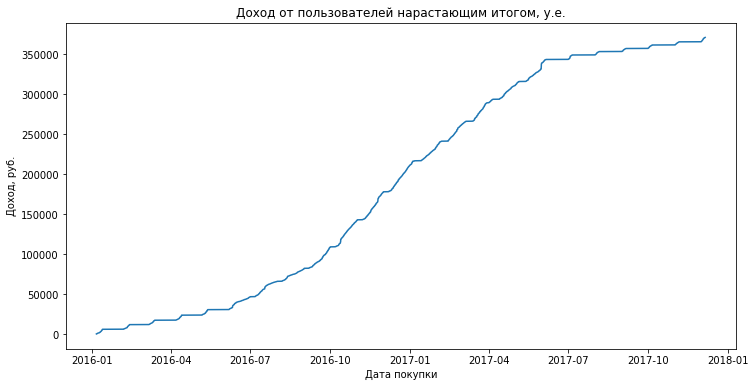

In [4]:
plt.figure(figsize = ( 12, 6))
plt.plot(purchases['buy_ts'], purchases['revenue'].cumsum())
plt.title("Доход от пользователей нарастающим итогом, у.е.")
plt.xlabel('Дата покупки')
plt.ylabel('Доход, руб.')

Судя по графику, доход активно рос с июля 2016 г. по июль 2017 г.

Разобьем покупки на 2 года и сравним средний доход от пользователя за 2 года.

In [5]:
purchases['year'] = purchases['buy_uts'].dt.year

In [6]:
purchases2016 = purchases[purchases['year'] == 2016]
purchases2017 = purchases[purchases['year'] == 2017]

In [7]:
purchases2017.head()

,buy_ts,uid,revenue,buy_uts,year
18646,2017-01-01 00:15:16,4147710234,3.05,2017-01-01 00:15:16+00:00,2017
10916,2017-01-01 00:42:38,739157339,4.89,2017-01-01 00:42:38+00:00,2017
70083,2017-01-01 00:44:28,2225160064,2.22,2017-01-01 00:44:28+00:00,2017
62718,2017-01-01 01:07:36,1225473222,2.44,2017-01-01 01:07:36+00:00,2017
31660,2017-01-01 01:10:15,1752543009,1.22,2017-01-01 01:10:15+00:00,2017


In [8]:
# сгруппируем данные по пользователю:
purchases_revenue_2016 = purchases2016.groupby('uid')['revenue'].agg({'sum': np.sum, 'count': 'count'})
purchases_revenue_2017 = purchases2017.groupby('uid')['revenue'].agg({'sum': np.sum, 'count': 'count'})

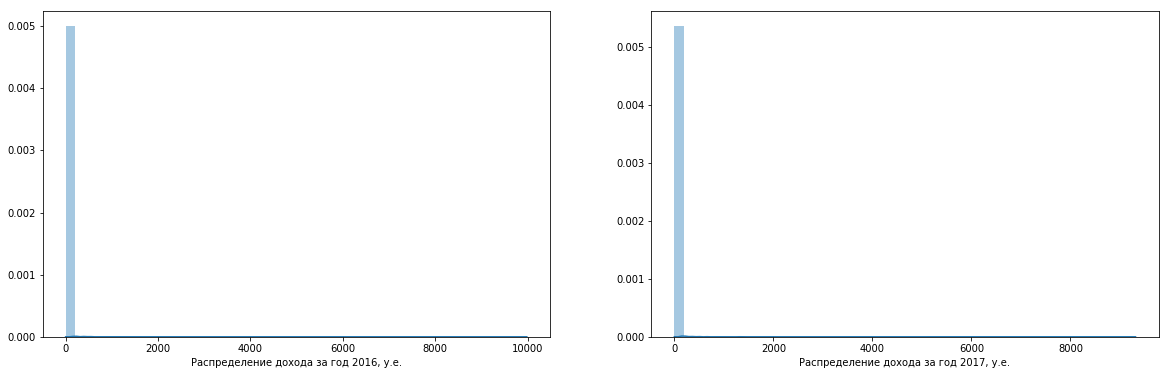

In [9]:
# Построим диаграмму распределения дохода от одного пользователя:
fig, axes = plt.subplots(1, 2, figsize=(20, 6))
for col, ax, year in zip([purchases_revenue_2016, purchases_revenue_2017], axes, ['2016', '2017']):
    sns.distplot(col['sum'], ax = ax)
    ax.set(xlabel = 'Распределение дохода за год {}, у.е.'.format(year))

**Вывод:** т.к. данные не распределены согласно нормальному распределению, использовать среднее арифметическое (mean) для описания среднего значения нельзя. Для оценки среднего попробуем разные метода: посчитаем медиану (median), усеченое среднее (удалим по 5% самых маленьких и больших наблюдений), посчитаем среднее логарифма.

In [10]:
# Сначала уберем пользователей, которые ничего не заплатили (работаем только с платящими пользователями)
paying_users_revenue_2016 =  purchases_revenue_2016[purchases_revenue_2016['sum'] > 0]
paying_users_revenue_2017 =  purchases_revenue_2017[purchases_revenue_2017['sum'] > 0]

In [11]:
print(purchases_revenue_2016.describe())

                       sum                count
count            32,279.00            32,279.00
mean                  6.56                 1.31
std                  68.00                 4.09
min                   0.00                 1.00
25%                   1.47                 1.00
50%                   2.87                 1.00
75%                   5.50                 1.00
max               9,979.98               554.00


In [12]:
# посчитаем средний доход по медиане:
print('Средний доход от платящего пользоваталя за 2016 год (медиана)', paying_users_revenue_2016.median()['sum'])
print('Средний доход от платящего пользоваталя за 2017 год (медиана)', paying_users_revenue_2017.median()['sum'])

Средний доход от платящего пользоваталя за 2016 год (медиана) 2.8899999999999997
Средний доход от платящего пользоваталя за 2017 год (медиана) 2.75


In [13]:
# посчитаем средний доход при помощи усеченного среднего (отсекаем 10% самых больших и маленьких наблюдений):
paying_users_revenue_2016['rev_group'] = pd.qcut(paying_users_revenue_2016['sum'], [0, 0.1, 0.9, 1], labels = [ 'low', 'medium', 'high'])
truncated2016_mean05 =  paying_users_revenue_2016[paying_users_revenue_2016['rev_group'] == 'medium'].mean()
print('Средний доход от платящего пользоваталя за 2016 год ( усеченое среднее)', truncated2016_mean05['sum'].round(2))

paying_users_revenue_2017['rev_group'] = pd.qcut(paying_users_revenue_2017['sum'], [0, 0.1, 0.9, 1], labels = ['low', 'medium', 'high'])
truncated2017_mean05 =  paying_users_revenue_2017[paying_users_revenue_2017['rev_group'] == 'medium'].mean()
print('Средний доход от платящего пользоваталя за 2017 год ( усеченое среднее)', truncated2017_mean05['sum'].round(2))


Средний доход от платящего пользоваталя за 2016 год ( усеченое среднее) 3.57
Средний доход от платящего пользоваталя за 2017 год ( усеченое среднее) 3.39


In [14]:
# прологорифмируем, найдем среднее и вернем экспоненту:
mean_log2016 = np.exp(np.log(purchases_revenue_2016['sum'] + 0.001).mean())
mean_log2017 = np.exp(np.log(purchases_revenue_2017['sum'] + 0.001).mean())

print('Средний доход от платящего пользоваталя за 2016 год (log_mean)', mean_log2016)
print('Средний доход от платящего пользоваталя за 2017 год (log_mean)', mean_log2017)

Средний доход от платящего пользоваталя за 2016 год (log_mean) 2.801879406584886
Средний доход от платящего пользоваталя за 2017 год (log_mean) 2.69962438435485


**Вывод:** Средний доход от пользователя - 2.75 у.е. за год. Я бы советовала не тратить больше этой суммы на привлечение нового платящего пользователя, если окупаемость должны быть год.

## Стоимость привлечения нового пользователя

In [15]:
# загрузим данные о визитах
visits = pd.read_csv('visits', sep= '\t', parse_dates = ['end_ts', 'start_dt', 'start_ts'])
visits.sort_values(by = 'start_ts', inplace=True)
visits.head()

,device,end_ts,source_id,start_dt,start_ts,uid
427678,desktop,2016-06-01 00:04:19+00:00,5,2016-06-01,2016-06-01 00:01:43+00:00,2648788064
514579,touch,2016-06-01 00:21:28+00:00,1,2016-06-01,2016-06-01 00:01:46+00:00,1862659328
290428,desktop,2016-06-01 00:04:22+00:00,3,2016-06-01,2016-06-01 00:02:15+00:00,2957100952
16835,desktop,2016-06-01 00:18:28+00:00,3,2016-06-01,2016-06-01 00:02:28+00:00,3670942567
144252,desktop,2016-06-01 00:04:44+00:00,3,2016-06-01,2016-06-01 00:02:34+00:00,3166540175


In [16]:
#Посмотрим, за какой период данные о визитах:
print('Данные о визитах начинаются с {} и заканчиваются {}'.format(visits['start_dt'].min(), visits['start_dt'].max()))

Данные о визитах начинаются с 2016-06-01 00:00:00 и заканчиваются 2017-05-31 00:00:00


In [17]:
# Посмотрим, за какой период имеют данные о покупках:
print('Даные о покупках начинаются с {} и заканчиваются {}'.format(purchases['buy_ts'].min(), purchases['buy_ts'].max()))

Даные о покупках начинаются с 2016-01-06 00:12:24 и заканчиваются 2017-12-05 23:24:31


**Покупки:** Имеются данные, начиная с 2016-01-06 00:12:24 и заканчивая 2017-12-05 23:24:31

**Визиты:** Имеются данные, начиная с 2016-06-01 00:00:00 и заканчивая 2017-05-31 00:00:00

**Вывод:** Данные о покупках и визитах собраны за разный период. Для анализа нужно выбрать период, где данные пересекаются, т. е.
2016-06-01 00:00:00 по 2017-05-31

In [18]:
purchases_cuted = purchases[(purchases['buy_ts'] >= visits['start_dt'].min()) & (purchases['buy_ts'] <= visits['start_dt'].max())]
print(purchases_cuted['buy_ts'].min())
print(purchases_cuted['buy_ts'].max())

2016-06-06 00:04:42
2017-05-30 23:59:44


In [19]:
print('Количество платящих клиетов:', len(list(set(purchases_cuted['uid']))))
print('Количество всех (платящих и неплатящих) клиетов:', len(list(set(visits['uid'])))) 

Количество платящих клиетов: 45850
Количество всех (платящих и неплатящих) клиетов: 380121


In [20]:
# добавим к данным о визитах информацию о доходах
df = pd.merge(visits, purchases_cuted, on = 'uid', how = 'outer')
# доход у пользователей задублировался. Исправим это.
# смотрим, если покупка была между началом и концом сессии, то оставляем доход, иначе удаляем.
df['revenue_upd'] = [rev if x <= y <= z else 0 for (x, y, z, rev) in zip(df['start_ts'], df['buy_uts'], df['end_ts'], df['revenue'] ) ]
  

In [21]:
# Проверим себя, чтобы мы ничего не потеряли по дороге:
print('Доход из файла с покупками: ', purchases_cuted['revenue'].sum().round())
print('Доход, перенесенный в файл с визитами: ', df['revenue_upd'].sum().round())
print('При переносе потеряли часть дохода в размере: ', (purchases_cuted['revenue'].sum() - df['revenue_upd'].sum()).round())

Доход из файла с покупками:  300780.0
Доход, перенесенный в файл с визитами:  250348.0
При переносе потеряли часть дохода в размере:  50432.0


При переносе дохода из одной таблици в другую потеряли часть дохода. Этому есть 2 причины:
    1. задвоенные сессии - у пользователя есть сессии, которые пересекаются во времени. Доход от таких сессий задвоился, его нужно убрать из таблицы;
    2. В таблице visit пропущены сессии пользоватей, т.е. в определенное время у пользователя была покупка, но данных о визите за это время нет. Такие покупки (без понимания, к какому визиту их отнести) добавлю в конец таблицы.

In [22]:
# Убираем дубли
df['dup'] = [str(x) +str(y)+str(z) if z >0 else 1 for (x, y, z) in zip(df['buy_uts'], df['uid'], df['revenue_upd'] ) ]




In [23]:
df_null = df[df['dup'] == 1]
df_not_null = df[df['dup'] != 1]

In [24]:
df_not_null = df_not_null.drop_duplicates(subset='dup', keep='first')
df_without_dup = pd.concat([df_null, df_not_null])
df_without_dup.sort_values(by = 'start_ts', inplace=True)

In [25]:
df_without_dup.head()

,device,end_ts,source_id,start_dt,start_ts,uid,buy_ts,revenue,buy_uts,year,revenue_upd,dup
0,desktop,2016-06-01 00:04:19+00:00,5,2016-06-01,2016-06-01 00:01:43+00:00,2648788064,NaT,nan,NaT,nan,0.00,1
1,touch,2016-06-01 00:21:28+00:00,1,2016-06-01,2016-06-01 00:01:46+00:00,1862659328,NaT,nan,NaT,nan,0.00,1
4,desktop,2016-06-01 00:04:22+00:00,3,2016-06-01,2016-06-01 00:02:15+00:00,2957100952,NaT,nan,NaT,nan,0.00,1
5,desktop,2016-06-01 00:18:28+00:00,3,2016-06-01,2016-06-01 00:02:28+00:00,3670942567,NaT,nan,NaT,nan,0.00,1
6,desktop,2016-06-01 00:04:44+00:00,3,2016-06-01,2016-06-01 00:02:34+00:00,3166540175,NaT,nan,NaT,nan,0.00,1


Посмотрим, что с потерянным доходом. После удаления дублей, потеряный доход должен увеличиться.

In [26]:
print('Доход из файла с покупками: ', purchases_cuted['revenue'].sum().round())
print('Доход, перенесенный в файл с визитами: ', df_without_dup['revenue_upd'].sum().round())
print('При переносе потеряли часть дохода в размере: ', (purchases_cuted['revenue'].sum() - df_without_dup['revenue_upd'].sum()).round())


Доход из файла с покупками:  300780.0
Доход, перенесенный в файл с визитами:  242227.0
При переносе потеряли часть дохода в размере:  58553.0


In [27]:
# Добавляем пропавший доход
purchases_revenue = purchases_cuted.groupby('uid')['revenue'].sum()
df_revenue = df_without_dup.groupby('uid')['revenue_upd'].sum()
df4 = pd.merge(purchases_revenue, df_revenue, on = 'uid')
df4.columns = ['purchases', 'visits']
df4['diff'] = df4['purchases'] - df4['visits']
df_missing = df4[df4['diff'] >0]
df_missing = df_missing.reset_index()

In [28]:
df_missing.columns = ['uid', 'purchases', 'visits', 'revenue_upd']
df_missing.head()

,uid,purchases,visits,revenue_upd
0,1472058,3.67,0.00,3.67
1,2751923,2.93,0.00,2.93
2,2826875,18.15,8.98,9.17
3,3457460,3.05,0.00,3.05
4,3825039,13.32,5.25,8.07


In [29]:
# обеъдиним таблицу, где доход очищен от дублей, и пропущенный доход
df_full = pd.concat([df_without_dup, df_missing])
df_full.head()

,buy_ts,buy_uts,device,dup,end_ts,purchases,revenue,revenue_upd,source_id,start_dt,start_ts,uid,visits,year
0,NaT,NaT,desktop,1,2016-06-01 00:04:19+00:00,nan,nan,0.00,5.00,2016-06-01,2016-06-01 00:01:43+00:00,2648788064,nan,nan
1,NaT,NaT,touch,1,2016-06-01 00:21:28+00:00,nan,nan,0.00,1.00,2016-06-01,2016-06-01 00:01:46+00:00,1862659328,nan,nan
4,NaT,NaT,desktop,1,2016-06-01 00:04:22+00:00,nan,nan,0.00,3.00,2016-06-01,2016-06-01 00:02:15+00:00,2957100952,nan,nan
5,NaT,NaT,desktop,1,2016-06-01 00:18:28+00:00,nan,nan,0.00,3.00,2016-06-01,2016-06-01 00:02:28+00:00,3670942567,nan,nan
6,NaT,NaT,desktop,1,2016-06-01 00:04:44+00:00,nan,nan,0.00,3.00,2016-06-01,2016-06-01 00:02:34+00:00,3166540175,nan,nan


In [30]:
# оставим в таблице только важные строки
df_full = df_full[['uid', 'device', 'start_ts', 'end_ts', 'buy_uts', 'revenue_upd', 'source_id']]
df_full.head()

,uid,device,start_ts,end_ts,buy_uts,revenue_upd,source_id
0,2648788064,desktop,2016-06-01 00:01:43+00:00,2016-06-01 00:04:19+00:00,NaT,0.00,5.00
1,1862659328,touch,2016-06-01 00:01:46+00:00,2016-06-01 00:21:28+00:00,NaT,0.00,1.00
4,2957100952,desktop,2016-06-01 00:02:15+00:00,2016-06-01 00:04:22+00:00,NaT,0.00,3.00
5,3670942567,desktop,2016-06-01 00:02:28+00:00,2016-06-01 00:18:28+00:00,NaT,0.00,3.00
6,3166540175,desktop,2016-06-01 00:02:34+00:00,2016-06-01 00:04:44+00:00,NaT,0.00,3.00


In [31]:
# Данные о доходах (покупках), о визитах которых ничего не известно, в конце таблице.
df_full.tail()

,uid,device,start_ts,end_ts,buy_uts,revenue_upd,source_id
10502,4293580593,NaN,NaT,NaT,NaT,0.92,nan
10503,4293969355,NaN,NaT,NaT,NaT,4.40,nan
10504,4294045341,NaN,NaT,NaT,NaT,1.10,nan
10505,4294759340,NaN,NaT,NaT,NaT,1.83,nan
10506,4294809969,NaN,NaT,NaT,NaT,0.61,nan


In [32]:
# кратко взглянем на данные
df_full.describe()

,uid,revenue_upd,source_id
count,"4,877,602.00","4,877,602.00","4,867,095.00"
mean,"2,139,031,550.27",0.06,2.93
std,"783,379,739.25",3.08,1.79
min,"4,245.00",0.00,1.00
25%,"1,986,260,154.00",0.00,1.00
50%,"1,986,260,154.00",0.00,2.00
75%,"2,293,904,136.00",0.00,5.00
max,"4,294,953,781.00","5,153.48",10.00


In [33]:
# Посчитаем количиство пользователей: 
users_num = df_full.groupby('uid')['revenue_upd'].sum().shape[0]
print('Количество пользователей, чел.:', users_num )
# Посчитаем количиство платящих пользователей:
paying_users_num = df_full[df_full['revenue_upd']>0].groupby('uid')['revenue_upd'].sum().shape[0]
print('Количество платящих пользователей, чел.:', paying_users_num)
# Посчитаем годовой доход:
revenur_per_year = df_full['revenue_upd'].sum()
print('Годовой доход, у.е.:', revenur_per_year)

Количество пользователей, чел.: 380121
Количество платящих пользователей, чел.: 45838
Годовой доход, у.е.: 300779.5900000001


In [34]:
pay_per_user = revenur_per_year / users_num 
oay_per_paying_users = revenur_per_year / paying_users_num

print('За пользователя готовы заплатить (среднее арифм.):', pay_per_user)
print('За платящего пользователя готовы заплатить (среднее арифм.):', oay_per_paying_users)

За пользователя готовы заплатить (среднее арифм.): 0.7912732787717598
За платящего пользователя готовы заплатить (среднее арифм.): 6.561795671713427


**Вывод:** опять-таки мы получили среднее арифметическое, которому в условиях нестандартного распределения довереять нельзя. Для устойчивости отсекем 3% пользователей с самым большим доходом и будем работать со средним арифметическим.

In [35]:
df_full_by_user = df_full.groupby('uid')['revenue_upd'].sum()
df_full_by_user = df_full_by_user.sort_values(ascending=False)

In [36]:
# Отрезаем 3% пользователей с самым большим доходом.
num_truncate = int(df_full_by_user.shape[0]*0.03)

In [37]:
# Получили урезаную табличку, где отсутвуют 3% пользователей с самым большим доходом.
df_full_by_user_truncated = df_full_by_user.iloc[num_truncate:]

In [38]:
# сколько готовы заплатить за привлечение пользователя
df_full_by_user_truncated.mean()

0.21457186793160676

In [39]:
# сколько готовы заплатить за привлечение платящего пользователя
df_full_by_user_truncated[df_full_by_user_truncated > 0].mean()

2.2975609118631097

In [40]:
# сколько готовы заплатить за привлечение платящего пользователя
df_full_by_user_truncated[df_full_by_user_truncated > 0].median()

2.1

**Вывод:** Т.к. изначально данные имеют нестандартное распределение, чтобы получить более устойчивые оценки, я удалила 3% пользователей с самым большим доходом, посчитав их выбросами. Такие пользователи сильно увеличивают средний доход от пользователя, и, следовательно, затраты, которые мы готовы понести на привлечение пользователей. Такие пользователи отличаются от типичных покупателей, их нужно рассматривать отдельно и далеко не факт, что мы сможем еще привлечать таких пользователей (с таким доходом и в таком количестве).

Удалив нестандартных пользователей, я бы дала рекоменданцию в среднем тратить на привлечение платящего пользователя 2,23 у.е., а на привлечение просто пользваоетля - 0.21 у.е. При таких затратах вложения окупятся за 1 год.

### Какой девайс / источник приносит больше дохода?

Text(0.5, 1.0, 'Доход, полученный из разных источников и девайсов, у.е.')

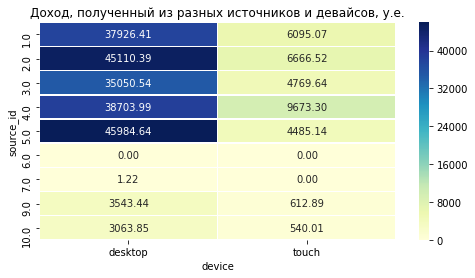

In [41]:
desktop_touch_table = df_full.pivot_table(index = 'source_id', columns= 'device', values='revenue_upd', aggfunc = np.sum )

plt.figure(figsize=(8, 4))
sns.heatmap(desktop_touch_table, cmap = 'YlGnBu', annot = True, fmt='.2f', linewidths=.5)
plt.title('Доход, полученный из разных источников и девайсов, у.е.')

**Вывод:** больше всего доходов Яндекс Афиша получает с desktop девайса и из 1, 2, 3, 4, 5 источников.

### Из какого источника / девайса больше всего покупок?

In [42]:
# добавим явный признак покупки
df_full['buy'] = [1 if x >0 else 0 for x in df_full['revenue_upd'] ]

Text(0.5, 1.0, 'Конверсия в платные визиты')

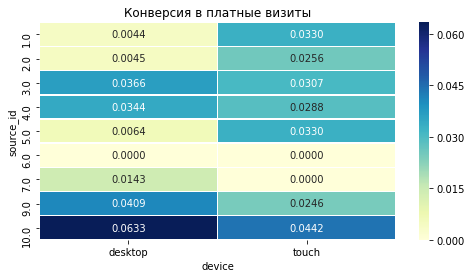

In [43]:
# посчитаем количество визитов с покупкой
desktop_touch_pay_visits_table = df_full.pivot_table(index = 'source_id', columns= 'device', values='buy', aggfunc = np.sum)

# посчитаем общее количество визитов
desktop_touch_visits_table = df_full.pivot_table(index = 'source_id', columns= 'device', values='buy', aggfunc = 'count')

# посчитаем конверсию
convertion_table = desktop_touch_pay_visits_table / desktop_touch_visits_table 

# построим график
plt.figure(figsize=(8, 4))
sns.heatmap(convertion_table, cmap = 'YlGnBu', annot = True, fmt='.4f', linewidths=.5)
plt.title('Конверсия в платные визиты')

**Вывод:** 
В целом конверсия из визитов в покупки выше:
1. у touch девайса;
2. у 3, 4, 9, 10 источников. 

Возможно, на рекламу в этих источниках / визитах стоит тратить в среднем больше денег.

### В какой день недели больше всего покупок?

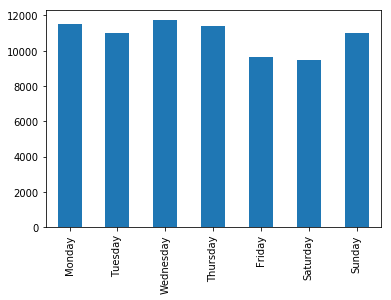

In [44]:
purchases['day_of_week'] = purchases['buy_ts'].dt.day_name()
purchases['hour']=purchases['buy_ts'].dt.hour
purchases_by_day_of_week = purchases['day_of_week'].value_counts()[['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday' ]]
purchases_by_day_of_week.plot(kind='bar')

**Вывод:** Больше всего билетов покупают в понедельник, среду, четверг и воскресенье. 
Меньше всего билетов покупают в пятницу и субботу.

### В какие часы больше всего покупок?

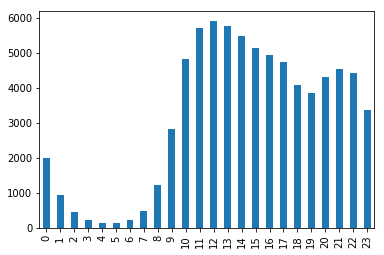

In [45]:
purchases_by_hour = purchases['hour'].value_counts().sort_index()
purchases_by_hour.plot(kind='bar')

**Вывод:** Есть аудитория, которая ходит на дневные (самая большая), на вечерние (поменьше) и ночные сейнсы.

### Взаимное влияние дня недели и часа на покупку билетов

In [46]:
purchases_table_revenue = purchases.pivot_table(index = 'hour', columns= 'day_of_week', values='revenue', aggfunc = np.sum )
purchases_table_revenue = purchases_table_revenue[['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday' ]]
purchases_table_revenue.head()

day_of_week,Monday,Tuesday,Wednesday,Thursday,Friday,Saturday,Sunday
hour,,,,,,,
0,"1,440.74","1,102.46","1,394.46","1,625.12","1,264.97","1,268.04","1,052.04"
1,562.66,530.00,585.96,670.08,745.14,601.38,648.18
2,311.68,261.77,279.63,207.48,288.69,266.31,296.89
3,89.58,163.01,230.86,116.68,172.41,175.84,135.92
4,99.62,51.64,93.12,66.00,76.78,61.56,40.07


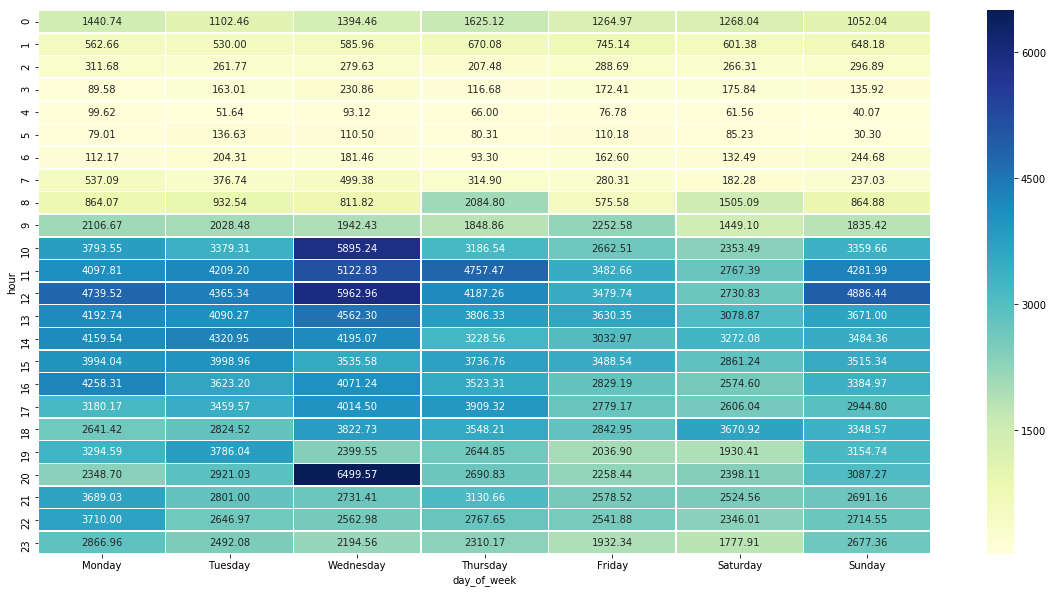

In [47]:
plt.figure(figsize=(20, 10))
sns.heatmap(purchases_table_revenue, cmap = 'YlGnBu', annot = True, fmt='.2f', linewidths=.5)

**Вывод:** выделяется среда.

## Посмотрим на когоротный анализ
Воможно не все активности приводят качественных клиентов.

In [48]:
def get_month(x): 
    return datetime(x.year, x.month, 1)

In [49]:
df.head()

,device,end_ts,source_id,start_dt,start_ts,uid,buy_ts,revenue,buy_uts,year,revenue_upd,dup
0,desktop,2016-06-01 00:04:19+00:00,5,2016-06-01,2016-06-01 00:01:43+00:00,2648788064,NaT,nan,NaT,nan,0.00,1
1,touch,2016-06-01 00:21:28+00:00,1,2016-06-01,2016-06-01 00:01:46+00:00,1862659328,NaT,nan,NaT,nan,0.00,1
2,touch,2016-06-03 19:18:18+00:00,2,2016-06-03,2016-06-03 19:12:10+00:00,1862659328,NaT,nan,NaT,nan,0.00,1
3,touch,2016-06-03 22:38:24+00:00,2,2016-06-03,2016-06-03 22:30:35+00:00,1862659328,NaT,nan,NaT,nan,0.00,1
4,desktop,2016-06-01 00:04:22+00:00,3,2016-06-01,2016-06-01 00:02:15+00:00,2957100952,NaT,nan,NaT,nan,0.00,1


In [141]:
df_full.head()

,uid,device,start_ts,end_ts,buy_uts,revenue_upd,source_id,buy,rev_group
0,2648788064,desktop,2016-06-01 00:01:43+00:00,2016-06-01 00:04:19+00:00,NaT,0.00,5.00,0,"(-0.001, 5153.48]"
1,1862659328,touch,2016-06-01 00:01:46+00:00,2016-06-01 00:21:28+00:00,NaT,0.00,1.00,0,"(-0.001, 5153.48]"
4,2957100952,desktop,2016-06-01 00:02:15+00:00,2016-06-01 00:04:22+00:00,NaT,0.00,3.00,0,"(-0.001, 5153.48]"
5,3670942567,desktop,2016-06-01 00:02:28+00:00,2016-06-01 00:18:28+00:00,NaT,0.00,3.00,0,"(-0.001, 5153.48]"
6,3166540175,desktop,2016-06-01 00:02:34+00:00,2016-06-01 00:04:44+00:00,NaT,0.00,3.00,0,"(-0.001, 5153.48]"


In [50]:
df['invoice_month'] = df['start_ts'].apply(get_month)

In [51]:
grouping = df.groupby('uid')['invoice_month']

In [52]:
df['cogort_month'] = grouping.transform('min')

In [53]:
def get_date_int(x): 
    year = x.dt.year 
    month = x.dt.month 
    day = x.dt.day 
    return year, month, day

In [54]:
invoice_year, invoice_month, _ = get_date_int(df['invoice_month']) 
cohort_year, cohort_month, _ = get_date_int(df['cogort_month'])

In [55]:
years_diff = invoice_year - cohort_year 
months_diff = invoice_month - cohort_month

In [56]:
df['CohortIndex'] = years_diff * 12 + months_diff + 1

In [57]:
# Подсчет ежемесячно активных клиентов из каждой когорты
grouping = df.groupby(['cogort_month', 'CohortIndex'])
cohort_data = grouping['uid'].apply(pd.Series.nunique)
cohort_data = cohort_data.reset_index()

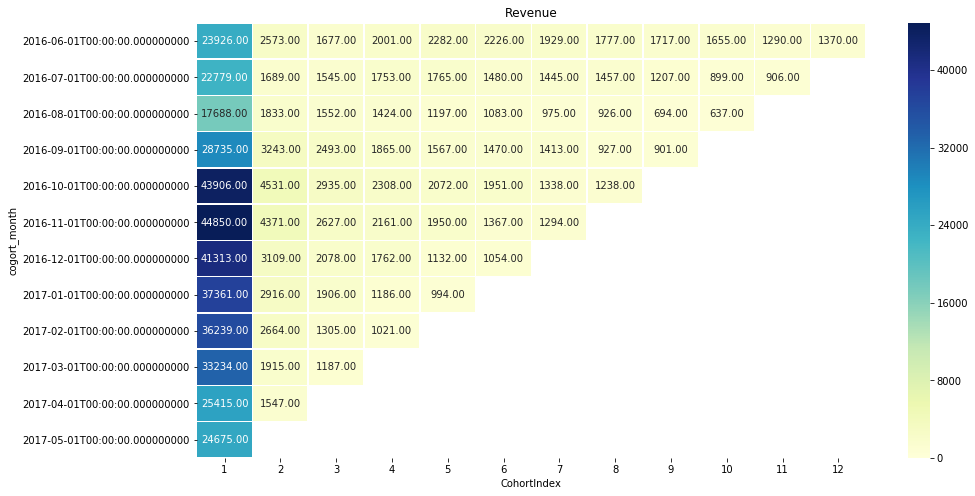

In [69]:
cohort_counts = cohort_data.pivot(index='cogort_month', columns='CohortIndex', values='uid')
plt.figure(figsize=(15, 8))
plt.title('Revenue')
sns.heatmap(data = cohort_counts, annot = True, fmt = '.2f', vmin = 0.0, cmap = 'YlGnBu', linewidths=.5)
plt.show()

## Calculate Retention rate

In [60]:
cohort_sizes = cohort_counts.iloc[:,0]
retention = cohort_counts.divide(cohort_sizes, axis=0)
retention.round(3) * 100
retention

cogort_month
2016-06-01              23,926.00
2016-07-01              22,779.00
2016-08-01              17,688.00
2016-09-01              28,735.00
2016-10-01              43,906.00
2016-11-01              44,850.00
2016-12-01              41,313.00
2017-01-01              37,361.00
2017-02-01              36,239.00
2017-03-01              33,234.00
2017-04-01              25,415.00
2017-05-01              24,675.00
Name: 1, dtype: float64

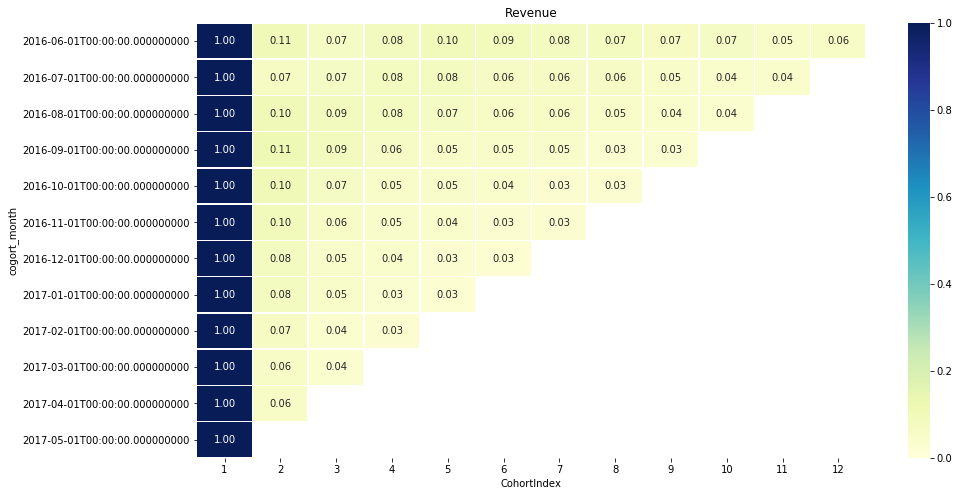

In [70]:
plt.figure(figsize=(15, 8))
plt.title('Revenue')
sns.heatmap(data = retention, annot = True, fmt = '.2f', vmin = 0.0, cmap = 'YlGnBu', linewidths=.5)
plt.show()

## Количество заработанных денег

In [71]:
grouping_revenue = df.groupby(['cogort_month', 'CohortIndex'])
cohort_data_revenue = grouping_revenue['revenue_upd'].apply(pd.Series.nunique)
cohort_data_revenue = cohort_data_revenue.reset_index()
cohort_data_revenue.head()

,cogort_month,CohortIndex,revenue_upd
0,2016-06-01,1,183
1,2016-06-01,2,102
2,2016-06-01,3,101
3,2016-06-01,4,160
4,2016-06-01,5,160


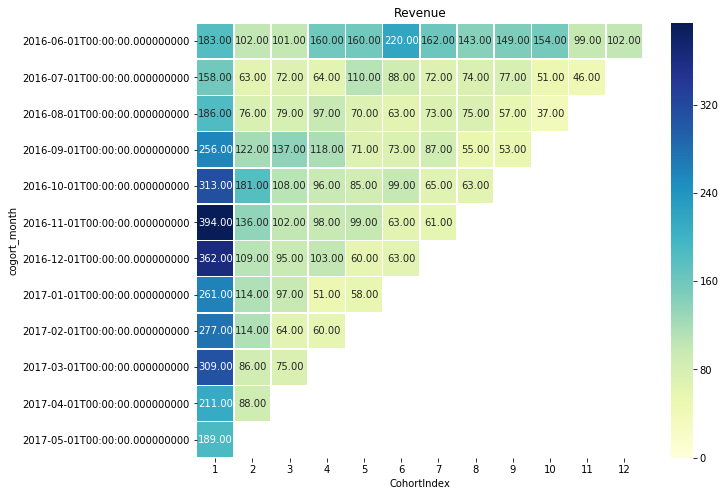

In [72]:
cohort_revenue = cohort_data_revenue.pivot(index='cogort_month', columns='CohortIndex', values='revenue_upd')
plt.figure(figsize=(10, 8))
plt.title('Revenue')
sns.heatmap(data = cohort_revenue, annot = True, fmt = '.2f', vmin = 0.0, cmap = 'YlGnBu', linewidths=.5)
plt.show()